In [1]:
import numpy as np
import numpy.ma as ma
import argparse
import sys
sys.path.append("./utils/")
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool,cpu_count
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

In [2]:
def unique_order(a):
    _, idx = np.unique(a, return_index=True)
    return a[np.sort(idx)]

In [3]:
params = np.loadtxt('/Users/costa/Repositories/fluctuating_potential_repo+data/fluctuating_potential/DW/sims_acfs_tau_s/iteration_Ts_eps.txt')
Tx = unique_order(params[:,0])[0]
Ts_range = unique_order(params[:,1])
eps_range = unique_order(params[:,2])
mu_s = np.sqrt(Tx)

In [4]:
f = h5py.File('../data/DW/sims_acfs_tau_s/acfs_0.h5','r')
print(f['metaData'].keys())
Tx = np.array(f['metaData/Tx'])[0]
dt = np.array(f['metaData/dt'])[0]
maxT = np.array(f['metaData/maxT'])[0]
f.close()

<KeysViewHDF5 ['Ts', 'Tx', 'dt', 'eps_s', 'iter_dt', 'maxT']>


In [5]:
C_nc_Ts_eps = []
Cc_Ts_eps = []
C_corr_Ts = []
idx=0
for Ts_idx,Ts in enumerate(Ts_range):
    C_nc_eps=[]
    Cc_eps=[]
    for eps_idx,eps in enumerate(eps_range):
        if idx==0:
            f = h5py.File('../data/DW/sims_acfs_tau_s/bootstrapped_acfs_{}.h5'.format(idx),'r')
            C_nc_ci = np.array(f['C_nc_ci'])
            C_c_ci = np.array(f['C_c_ci'])
            C_corr = np.array(f['C_corr'])
            lags = np.array(f['lags'],dtype=int)
            trange = np.array(f['trange'])
            f.close()
        else:
            f = h5py.File('../data/DW/sims_acfs_tau_s/bootstrapped_acfs_{}.h5'.format(idx),'r')
            C_nc_ci = np.array(f['C_nc_ci'])
            C_c_ci = np.array(f['C_c_ci'])
            C_corr = np.array(f['C_corr'])
            f.close()
        C_nc_eps.append(C_nc_ci)
        Cc_eps.append(C_c_ci)
        idx+=1
    Cc_Ts_eps.append(np.array(Cc_eps))
    C_nc_Ts_eps.append(np.array(C_nc_eps))
    C_corr_Ts.append(np.array(C_corr))

0.28862745
0
0.1324878
1
0.06803504
2
0.036239713
3
0.018774362
4
0.011673644
5
0.0071225897
6
0.0032611634
7


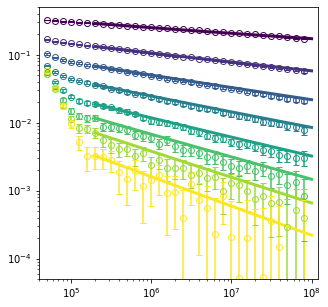

In [6]:
eps_idx=8
plt.figure(figsize=(5,5))
stride=3
colors_Ts = plt.cm.viridis(np.linspace(0,1,len(Ts_range)))
for Ts_idx in range(len(Ts_range)):
    Ts = Ts_range[Ts_idx]
    C_nc_sims = C_nc_Ts_eps[Ts_idx][eps_idx][:-1][::stride]
    mean,cil,ciu = C_nc_sims[:,0],C_nc_sims[:,1],C_nc_sims[:,2]
    sel = mean>0
    plt.errorbar(lags[:-1][::stride][sel]*dt,mean[sel],yerr = [mean[sel]-cil[sel],ciu[sel]-mean[sel]],capsize=3,fmt='o',c=colors_Ts[Ts_idx],mfc='none')
    plt.yscale('log')
    plt.xscale('log')
    idx=np.argmin(np.abs(lags[::stride]*dt-2e5))
    lags_plot = lags[::stride][idx:]
    print(mean[idx])
    line_plot = (lags_plot*dt)**(-Tx/(2*Ts))*np.log(lags_plot*dt)**(-.5)
    plt.plot(lags_plot*dt,mean[idx]*line_plot/line_plot[0],c=colors_Ts[Ts_idx],lw=3)
    print(Ts_idx)
plt.ylim(5e-5,5e-1)
plt.xlim(4e4,1.2e8)
# plt.savefig('C_nc_temps_eps_{:.2f}.pdf'.format(eps_range[eps_idx]))
plt.show()

<ipython-input-7-f97abcdc682c>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


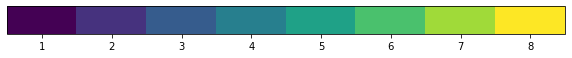

In [7]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_Ts)
cmap.set_over('0.')
cmap.set_under('1.0')

bounds =  np.arange(9)+.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(9),
                                spacing='proportional',
                                orientation='horizontal')
# plt.savefig('colorbar_Ts_range_largest_eps.pdf')
fig.show()


# connected acf 

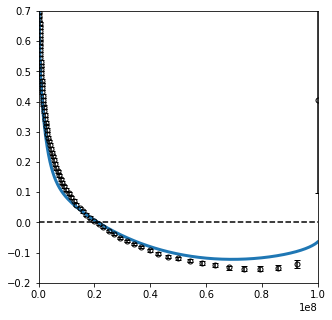

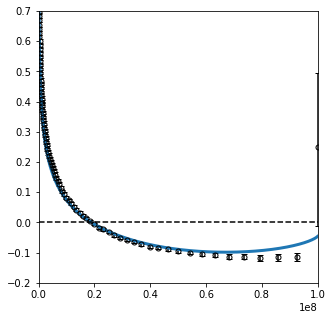

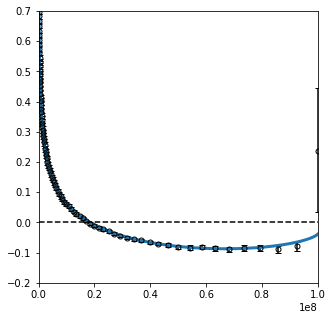

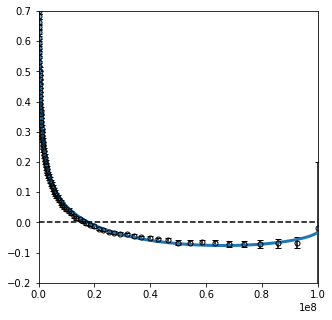

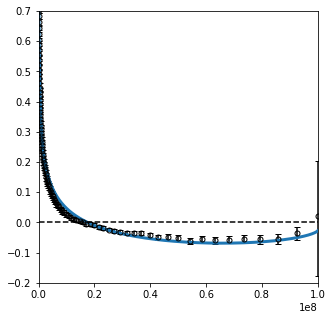

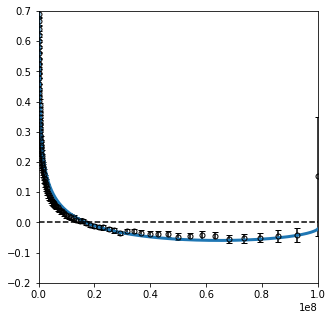

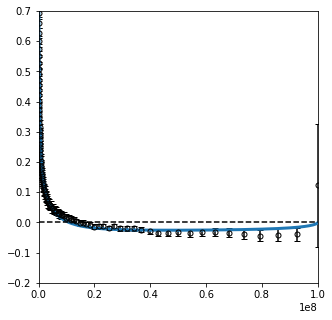

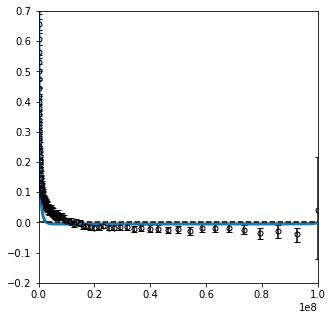

In [8]:
eps_idx=8
for Ts_idx in range(len(Ts_range)):
    plt.figure(figsize=(5,5))
    Ts = Ts_range[Ts_idx]
    Cc = C_corr_Ts[Ts_idx]
    mean,cil,ciu = Cc_Ts_eps[Ts_idx][eps_idx][:,0],Cc_Ts_eps[Ts_idx][eps_idx][:,1],Cc_Ts_eps[Ts_idx][eps_idx][:,2]
#     print(mean.shape,lags.shape,trange.shape)
    plt.errorbar(lags*dt,mean,yerr = [mean-cil,ciu-mean],fmt='o',c='k',capsize=3,mfc='None',ms=5)
    plt.plot(trange,Cc/Cc[0],lw=3)
    plt.ylim(-.2,.7)
    plt.xlim(0,1e8)
    plt.axhline(c='k',ls='--')
    # plt.xscale('log')
#     plt.savefig('CC_corrected_Ts_idx_{}_eps_idx_{}.pdf'.format(Ts_idx,eps_idx))
    plt.show()

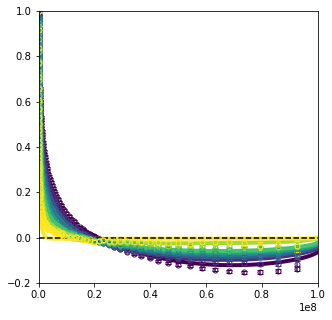

In [9]:
plt.figure(figsize=(5,5))
colors_Ts = plt.cm.viridis(np.linspace(0,1,len(Ts_range)))
for Ts_idx in range(len(Ts_range)):
    Ts = Ts_range[Ts_idx]
    Cc = C_corr_Ts[Ts_idx]
    mean,cil,ciu = Cc_Ts_eps[Ts_idx][eps_idx][:-1,0],Cc_Ts_eps[Ts_idx][eps_idx][:-1,1],Cc_Ts_eps[Ts_idx][eps_idx][:-1,2]
    plt.errorbar(lags[:-1]*dt,mean,yerr = [mean-cil,ciu-mean],fmt='o',c=colors_Ts[Ts_idx],capsize=3,mfc='None',ms=5)
    plt.plot(trange,Cc/Cc[0],lw=4,c=colors_Ts[Ts_idx])

# plt.plot(lags*dt,mean)
plt.ylim(-.2,1)
plt.xlim(0,1e8)
plt.axhline(c='k',ls='--')
# plt.savefig('CC_corrected_all_Ts_eps_idx_{}.pdf'.format(eps_idx))
# plt.xscale('log')
plt.show()

# Theory

In [10]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def potential(x,s):
    return s**2*(x**2-1)**2

def exppot(x, Tx,s,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,s)/Tx)*fun(x)

def omega_be(Tx,s):
    z = np.linspace(-20, 0, 1000)
    iarr = cumtrapz(exppot(z,Tx,s), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumtrapz(exppot(y,Tx,s, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)
    
    return 1/(2*ofun(0))

acf = lambda t, s, Tx : np.exp(-2*omega_be(Tx,s)*t)
F = lambda s, t, Tx, Ts, mu_s : np.exp(-((s - mu_s)**2/(2*Ts)))*acf(t, s, Tx)

def C_corr(r_range,Cr,N):
    sum1 = (2*(N-np.arange(1,N-1))*Cr[1:N-1]).sum()
    Cr_range = np.zeros(len(r_range))
    for kr,r in enumerate(r_range):
        term1 = (1/N)*(1/N - 2/(N-kr))*(N*Cr[0]+sum1)
        if kr==0:
            sum2=0
        else:
            sum2 =(2*(kr-np.arange(1,kr-1))*Cr[1:kr-1]).sum()
        sum3 = (Cr[1:N-1]*(np.min([np.arange(1,N-1)+kr,N*np.ones(N-2)],axis=0)-np.max([kr*np.ones(N-2),np.arange(1,N-1)],axis=0))).sum()
        term2 = (2/(N*(N-kr)))*(kr*Cr[0]+sum2+sum3)
        Cr_range[kr] = Cr[kr]+term1+term2
    return Cr_range

def get_corrected_acf(mu_s,Ts,lags_corr,trange):
    srange = np.linspace(mu_s-20*Ts,mu_s+20*Ts,100)
    ds = srange[1]-srange[0]
    F_int= np.zeros(trange.shape)
    for s in srange:
        F_int+=F(s,trange,Tx,Ts,mu_s)*ds
    Cc = C_corr(lags_corr,F_int,len(lags_corr))
    return F_int,Cc


def bootstrap_norm_acfs(Cc,n_times=100):
    C_boot=[]
    for k in range(n_times):
        C_sample = Cc[np.random.randint(0,len(Cc),len(Cc))].mean(axis=0)
        C_norm = C_sample/C_sample[0]
        C_boot.append(C_norm)
    mean = Cc.mean(axis=0)
    mean = mean/mean[0]
    
    cil = np.percentile(C_boot,2.5,axis=0)
    ciu = np.percentile(C_boot,97.5,axis=0)
    return mean,cil,ciu


# Ts_range_corr = np.arange(.01,5,0.01)*Tx
# lags_corr = np.arange(lags[0],lags[-1],1e3)
# trange_corr = lags_corr*dt

# Cc_Ts = np.zeros((len(Ts_range_corr),lags_corr.shape[0]))
# for kTs,Ts in enumerate(Ts_range_corr):
#     srange = np.linspace(mu_s-10*np.sqrt(Ts),mu_s+10*np.sqrt(Ts),5000)
#     ds = srange[1]-srange[0]
#     F_int = np.zeros(trange.shape)
#     for s in srange:
#         F_int+=F(s,trange,Tx,Ts,mu_s)*ds
#     Cc = C_corr(lags_corr,F_int,len(lags_corr))
#     Cc_Ts[kTs] = Cc
#     print(kTs)
    
f = h5py.File('Cc_Ts.h5','r')
lags_corr = np.array(f['lags_corr'])
trange_corr = np.array(f['trange_corr'])
Ts_range_corr = np.array(f['Ts_range_corr'])
Cc_Ts = np.array(f['Cc_Ts'])
f.close()

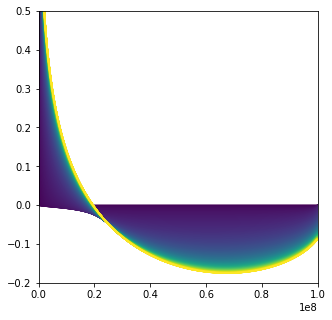

In [11]:
plt.figure(figsize=(5,5,))
colors_Ts = plt.cm.viridis(np.linspace(0,1,len(Ts_range_corr)))
for kTs,Ts in enumerate(Ts_range_corr):
    plt.plot(trange_corr,Cc_Ts[kTs]/Cc_Ts[kTs][0],c=colors_Ts[kTs])
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1,1e3)
plt.ylim(-.2,.5)
plt.xlim(0,1e8)
plt.show()

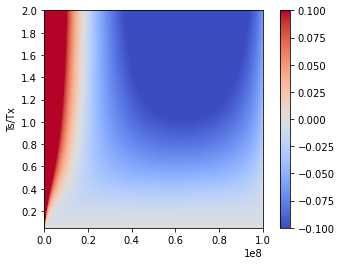

In [12]:
plt.imshow((Cc_Ts.T/Cc_Ts[:,0]).T,cmap='coolwarm',vmax=.1,vmin=-.1,origin='lower',aspect=5.1e7,extent=[trange[0],trange[-1],Ts_range_corr[0]/Tx,Ts_range_corr[-1]/Tx])
plt.colorbar()
plt.yticks(Ts_range_corr[19:][::20]/Tx)
plt.ylabel('Ts/Tx')
plt.ylim(0.05,2)
plt.xlim(0,1e8)
plt.savefig('Cc_norm.pdf')
plt.show()

# Effect of tau_s

2


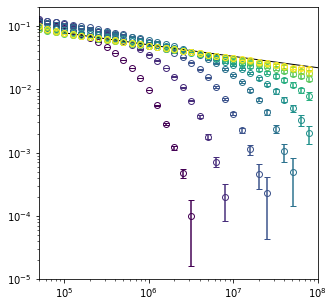

0
1
2
3
4
5
6
7
8


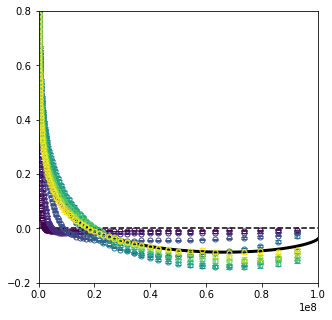

In [13]:
plt.figure(figsize=(5,5))
stride=3
Ts_idx=2
Ts = Ts_range[Ts_idx]
colors_eps = plt.cm.viridis(np.linspace(0,1,len(eps_range)))
for eps_idx in range(len(eps_range)):
    C_nc_sims = C_nc_Ts_eps[Ts_idx][eps_idx][:-1][::stride]
    mean,cil,ciu = C_nc_sims[:,0],C_nc_sims[:,1],C_nc_sims[:,2]
    sel = cil>0
    plt.errorbar(lags[:-1][::stride][sel]*dt,mean[sel],yerr = [mean[sel]-cil[sel],ciu[sel]-mean[sel]],capsize=3,fmt='o',c=colors_eps[eps_idx],mfc='none')
plt.yscale('log')
plt.xscale('log')
idx=np.argmin(np.abs(lags[::stride]*dt-1e5))
lags_plot = lags[::stride][idx:]
line_plot = (lags_plot*dt)**(-Tx/(2*Ts))*np.log(lags_plot*dt)**(-.5)
plt.plot(lags_plot*dt,mean[idx]*line_plot/line_plot[0],c='k',lw=1)
print(Ts_idx)
plt.ylim(1e-5,2e-1)
plt.xlim(5e4,1e8)
# plt.savefig('C_nc_all_eps_Ts_{:.3f}.pdf'.format(Ts))
plt.show()


plt.figure(figsize=(5,5))
for eps_idx in range(len(eps_range)):
    mean,cil,ciu = Cc_Ts_eps[Ts_idx][eps_idx][:-1,0],Cc_Ts_eps[Ts_idx][eps_idx][:-1,1],Cc_Ts_eps[Ts_idx][eps_idx][:-1,2]
    plt.errorbar(lags[:-1]*dt,mean,yerr = [mean-cil,ciu-mean],fmt='o',c=colors_eps[eps_idx],capsize=3,mfc='None',ms=5)
    print(eps_idx)
Cc = C_corr_Ts[Ts_idx]
plt.plot(trange,Cc/Cc[0],lw=3,c='k')
plt.ylim(-.2,.8)
plt.xlim(0,1e8)
plt.axhline(c='k',ls='--')
# plt.xscale('log')
# plt.savefig('CC_corrected_Ts_idx_{}_all_eps.pdf'.format(Ts_idx))
plt.show()

<ipython-input-14-d7fe975d87b7>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


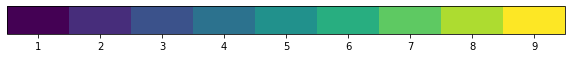

In [14]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_eps)
cmap.set_over('0.')
cmap.set_under('1.0')

bounds =  np.arange(10)+.5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(10),
                                spacing='proportional',
                                orientation='horizontal')
# plt.savefig('colorbar_eps_range.pdf')
fig.show()


# Estimate finite-size corrections for forced OU acf

In [15]:
Tx = .1
Ts = .1
fpt_range = np.logspace(-2.,2.,201)*maxT
lags_corr = np.linspace(0,int(maxT/dt),1001)
trange = lags_corr*dt
Cc_fpt = np.zeros((len(fpt_range),len(trange)))
C_fpt = np.zeros((len(fpt_range),len(trange)))
for k,fpt in enumerate(fpt_range):    
    C = np.exp(-trange)*(Tx+ (Ts/fpt)/((1/fpt)**(-2)-1))+np.exp(-trange/fpt)*Ts/(1-(1/fpt)**2)
    Cc = C_corr(lags_corr,C,len(lags_corr))
    Cc_fpt[k] = Cc/Cc[0]
    C_fpt[k] = C

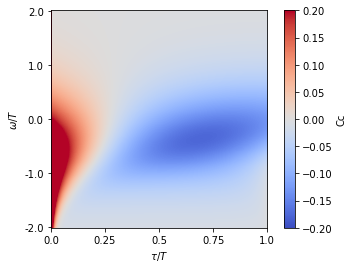

In [16]:
plt.imshow(Cc_fpt,aspect=5,cmap='coolwarm',vmin=-.2,vmax=.2,origin='lower')
plt.yticks(np.arange(0,201,50),np.linspace(-2,2,201)[::50])
plt.colorbar(label='Cc')
plt.xticks(np.arange(0,len(lags_corr),250),lags_corr[::250]/(maxT/dt))
plt.ylabel(r'$\omega/T$')
plt.xlabel(r'$\tau/T$')
# plt.savefig('finite_size_exp_tails.pdf')
plt.show()